# Imports

In [ ]:
# importing libraries, modules, and some useful functions
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.utils import img_to_array

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

import torch
from torch.nn import Sequential # making the feature extractor
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import datasets, models, transforms

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Functions

In [ ]:
# function to load a single image from the dataset
def load_image(id):
    img = cv2.imread(str(id) + '.jpg')
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# function to load multiple images to give input to the models
def load_images(ids, img_size):
    images = np.ndarray(shape=(len(ids), img_size, img_size, 3), dtype=np.float32)
    for i in range(len(ids)):
        temp = cv2.imread(str(ids[i]) + '.jpg')
        temp = cv2.resize(temp, (img_size, img_size), interpolation=cv2.INTER_AREA)
        images[i] = img_to_array(temp)
    return images/255.0

# function to plot the accuracy for every epoch while training the deep learning models
def plot_train(history):
    plt.plot(range(1, EPOCHS + 1), history.history['categorical_accuracy'])
    plt.plot(range(1, EPOCHS + 1), history.history['val_categorical_accuracy'])
    plt.xticks(range(0, EPOCHS + 1, EPOCHS//5 + 1))
    plt.legend(['Training', 'Validations'])
    plt.grid(linestyle='--')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    return

# function to show the results of a trained model on the test data
def show_results(model):
    preds = model.predict(x_test)
    try: pred = np.argmax(preds, axis=1)
    except: pred = preds
    try: test = np.argmax(y_test, axis=1)
    except: test = y_test
    print(f"Accuracy: {accuracy_score(test, pred)}, \nF1 score: {f1_score(test, pred, average='weighted')}")
    ConfusionMatrixDisplay(confusion_matrix(test, pred), display_labels=cols).plot()
    plt.show()
    return

# function to compute the features of an image using resnet18 as a feature extractor
def features(id, img_size, model):
    img = cv2.resize(cv2.imread(str(id) + '.jpg'), (img_size, img_size), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32') / 255.0
    img -= MEAN
    img /= STD
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img,  0)
    return model(torch.from_numpy(img)).detach().numpy()[0, :, 0, 0]

# Dataset overview

In [ ]:
# accessing the images from google drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/project769

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/project769


In [ ]:
# loading the file with class labels for each image
df = pd.read_csv('train.csv')
cols = df.columns[1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In [ ]:
# we see that one-hot bit encoding has been done for the multiple classes
df.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

/content/gdrive/MyDrive/project769/images


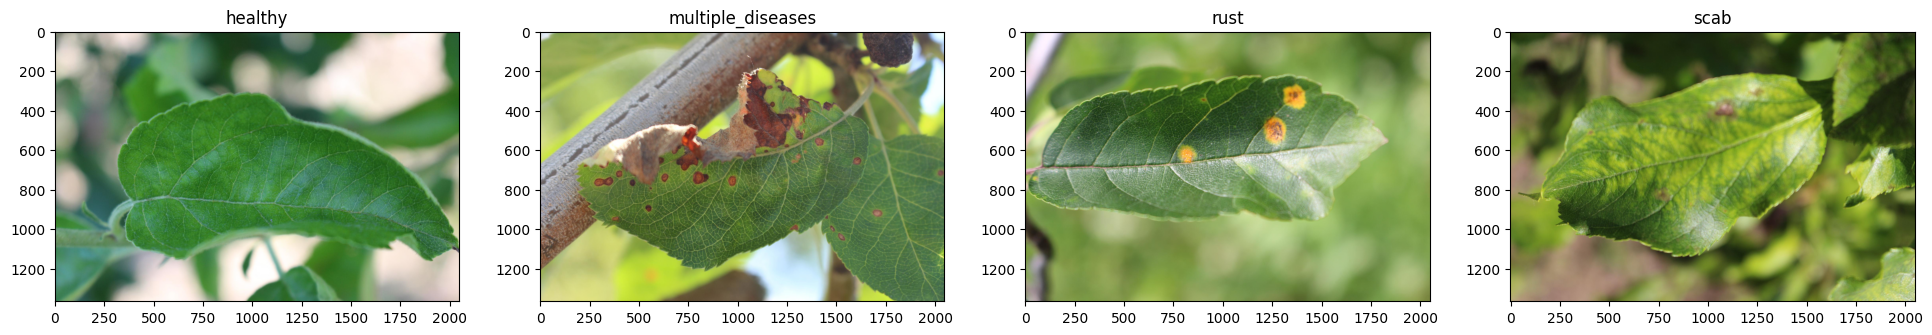

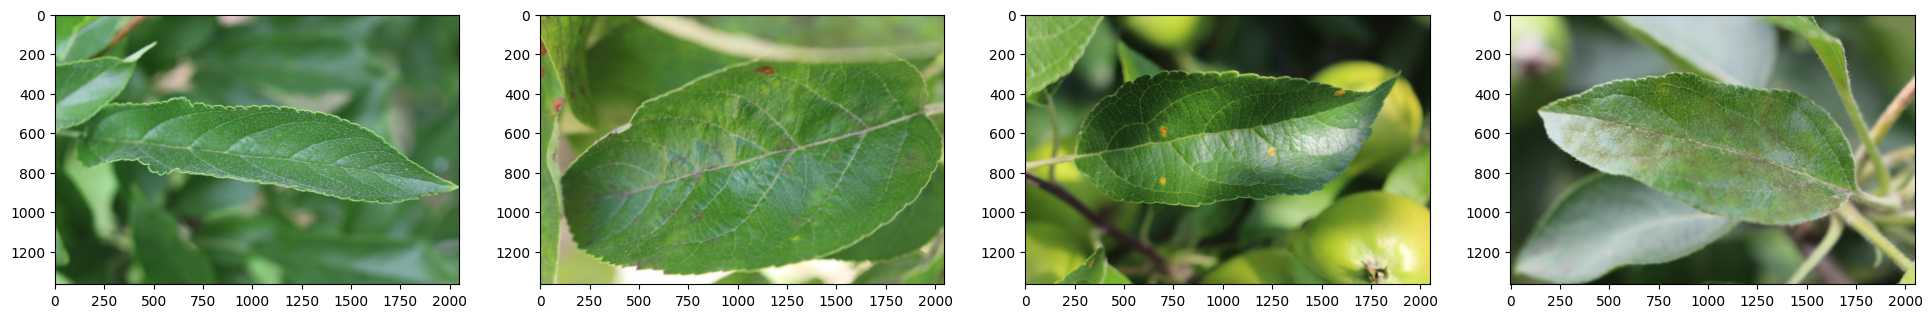

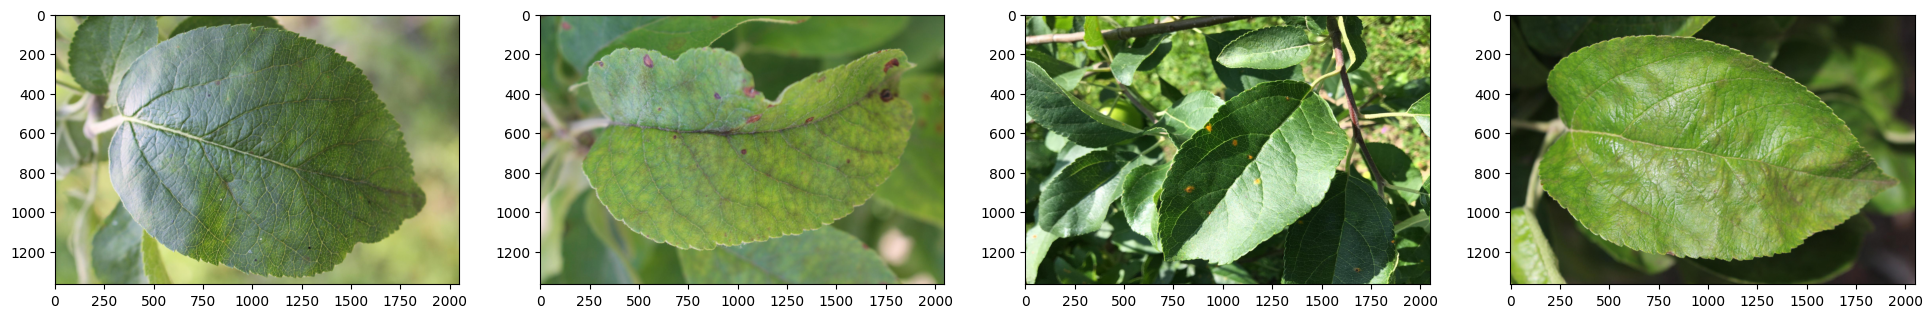

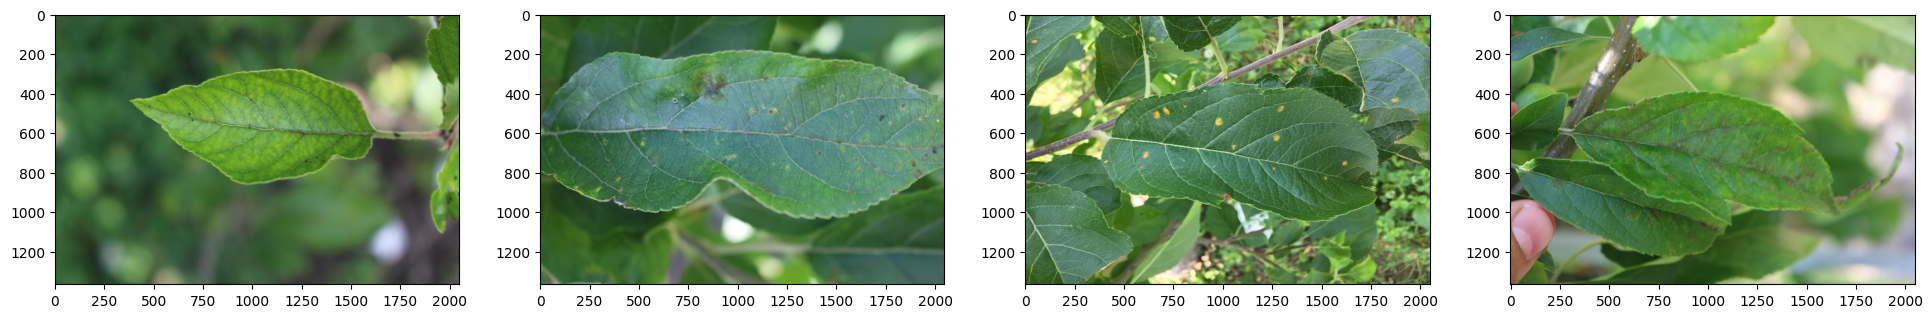

In [ ]:
# displaying a few sample images belonging to each of the classes
%cd images
for j in range(4):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))
    for i in range(4):
        ax[i].imshow(load_image(df.image_id[df[cols[i]] == 1].iloc[j]))
        if j == 0: ax[i].title.set_text(cols[i])

# Data Splitting

In [ ]:
# image dimensions for input to the models
img_size = 224

# spliiting the data in training validation and testing
x_train, x_test, y_train, y_test = map(lambda x: np.array(x.values), train_test_split(df.image_id, df[cols], test_size = 0.15))
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3)

# loading all the images into memory
x_train, x_val, x_test = map(lambda x: load_images(x, img_size), (x_train, x_val, x_test))

# Densenet121

In [ ]:
# parameters for training
EPOCHS = 20
BATCH_SIZE = 32
STEPS_PER_EPOCH = y_train.shape[0] // BATCH_SIZE

In [ ]:
# defining the Densenet121 model with custom output layer (for four classes)
model = tf.keras.Sequential(
    [
    DenseNet121(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
    L.GlobalAveragePooling2D(),
    L.Dense(y_train.shape[1], activation='softmax')
    ])
    
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 4100      
                                                                 
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
# training the model
history = model.fit(x = x_train, y = y_train, epochs = EPOCHS,
                    steps_per_epoch = y_train.shape[0] // BATCH_SIZE,
                    validation_data = (x_val, y_val))

Epoch 1/20
33/33 [==============================] - 107s 778ms/step - loss: 0.6937 - categorical_accuracy: 0.7708 - val_loss: 70.5348 - val_categorical_accuracy: 0.3097
Epoch 2/20
33/33 [==============================] - 13s 396ms/step - loss: 0.3928 - categorical_accuracy: 0.8743 - val_loss: 23.3948 - val_categorical_accuracy: 0.3075
Epoch 3/20
33/33 [==============================] - 14s 437ms/step - loss: 0.1976 - categorical_accuracy: 0.9335 - val_loss: 1.2866 - val_categorical_accuracy: 0.8129
Epoch 4/20
33/33 [==============================] - 13s 399ms/step - loss: 0.1431 - categorical_accuracy: 0.9593 - val_loss: 1.9288 - val_categorical_accuracy: 0.7398
Epoch 5/20
33/33 [==============================] - 14s 435ms/step - loss: 0.1133 - categorical_accuracy: 0.9547 - val_loss: 0.9636 - val_categorical_accuracy: 0.8473
Epoch 6/20
33/33 [==============================] - 14s 433ms/step - loss: 0.0874 - categorical_accuracy: 0.9723 - val_loss: 2.0523 - val_categorical_accuracy: 0.

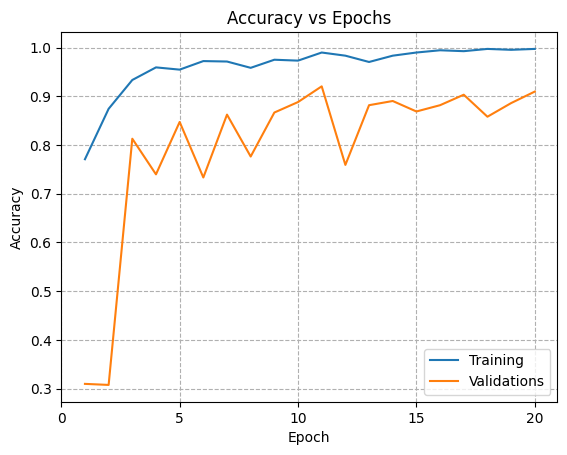

In [ ]:
# plotting the training and validation accuracy for every epoch
plot_train(history)

9/9 [==============================] - 4s 298ms/step
Accuracy: 0.8978102189781022, 
F1 score: 0.8889762228576745


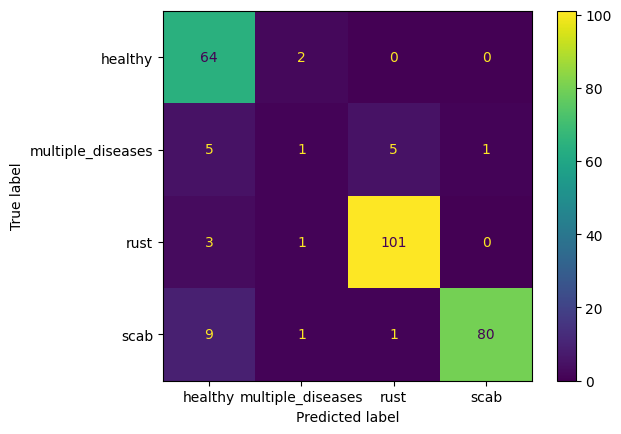

In [ ]:
# showing the results on the test data: accuracy, f1-score and the confusion matrix
show_results(model)

# VGG16

In [ ]:
# parameters for training
EPOCHS = 20
BATCH_SIZE = 32
STEPS_PER_EPOCH = y_train.shape[0] // BATCH_SIZE

In [ ]:
# defining the VGG16 model with custom output layer (for four classes)
model = tf.keras.Sequential(
    [
    VGG16(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
    L.GlobalAveragePooling2D(),
    L.Dense(y_train.shape[1], activation='softmax')
    ])
    
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 14,716,740
Trainable params: 14,716,740
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# training the model
history = model.fit(x = x_train, y = y_train, epochs = EPOCHS,
                    steps_per_epoch = y_train.shape[0] // BATCH_SIZE,
                    validation_data = (x_val, y_val))

Epoch 1/20
33/33 [==============================] - 47s 550ms/step - loss: 2.4466 - categorical_accuracy: 0.3327 - val_loss: 1.2352 - val_categorical_accuracy: 0.3204
Epoch 2/20
33/33 [==============================] - 17s 511ms/step - loss: 1.2774 - categorical_accuracy: 0.3133 - val_loss: 1.2931 - val_categorical_accuracy: 0.2753
Epoch 3/20
33/33 [==============================] - 16s 501ms/step - loss: 1.2559 - categorical_accuracy: 0.3272 - val_loss: 1.2232 - val_categorical_accuracy: 0.3355
Epoch 4/20
33/33 [==============================] - 17s 522ms/step - loss: 1.2423 - categorical_accuracy: 0.3420 - val_loss: 1.2370 - val_categorical_accuracy: 0.3441
Epoch 5/20
33/33 [==============================] - 17s 520ms/step - loss: 1.2496 - categorical_accuracy: 0.3475 - val_loss: 1.2208 - val_categorical_accuracy: 0.3355
Epoch 6/20
33/33 [==============================] - 17s 522ms/step - loss: 1.2352 - categorical_accuracy: 0.3586 - val_loss: 1.2046 - val_categorical_accuracy: 0.397

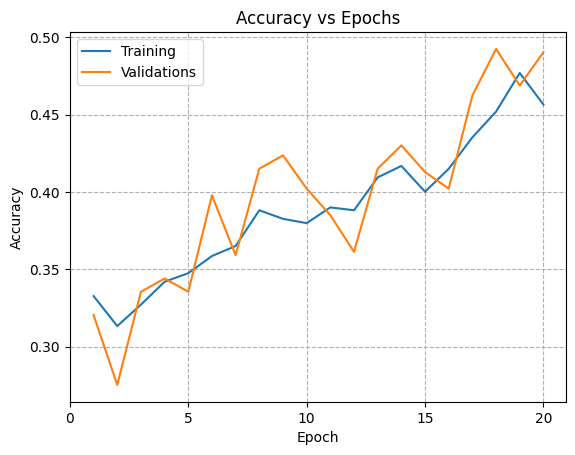

In [ ]:
# plotting the training and validation accuracy for every epoch
plot_train(history)

9/9 [==============================] - 1s 121ms/step
Accuracy: 0.4708029197080292, 
F1 score: 0.4524124055483664


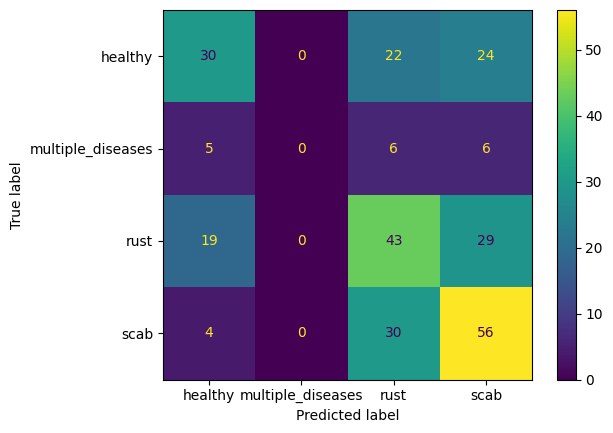

In [ ]:
# showing the results on the test data: accuracy, f1-score and the confusion matrix
show_results(model)

# Resnet50

In [ ]:
# parameters for training
EPOCHS = 20
BATCH_SIZE = 32
STEPS_PER_EPOCH = y_train.shape[0] // BATCH_SIZE

In [ ]:
# defining the ResNet50 model with custom output layer (for four classes)
model = tf.keras.Sequential(
    [
    ResNet50(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
    L.GlobalAveragePooling2D(),
    L.Dense(y_train.shape[1], activation='softmax')
    ])
    
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# training the model
history = model.fit(x = x_train, y = y_train, epochs = EPOCHS,
                    steps_per_epoch = y_train.shape[0] // BATCH_SIZE,
                    validation_data = (x_val, y_val))

Epoch 1/20
33/33 [==============================] - 71s 599ms/step - loss: 0.8290 - categorical_accuracy: 0.7828 - val_loss: 1586.6195 - val_categorical_accuracy: 0.3183
Epoch 2/20
33/33 [==============================] - 13s 395ms/step - loss: 0.3830 - categorical_accuracy: 0.8993 - val_loss: 163.0145 - val_categorical_accuracy: 0.0602
Epoch 3/20
33/33 [==============================] - 13s 400ms/step - loss: 0.2294 - categorical_accuracy: 0.9168 - val_loss: 5.6034 - val_categorical_accuracy: 0.3011
Epoch 4/20
33/33 [==============================] - 12s 365ms/step - loss: 0.1406 - categorical_accuracy: 0.9529 - val_loss: 4.0867 - val_categorical_accuracy: 0.3011
Epoch 5/20
33/33 [==============================] - 13s 405ms/step - loss: 0.0934 - categorical_accuracy: 0.9695 - val_loss: 6.3290 - val_categorical_accuracy: 0.3011
Epoch 6/20
33/33 [==============================] - 13s 410ms/step - loss: 0.0978 - categorical_accuracy: 0.9677 - val_loss: 1.6835 - val_categorical_accuracy: 

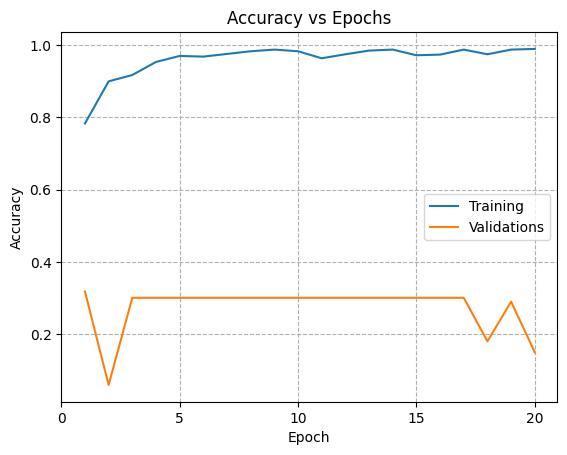

In [ ]:
# plotting the training and validation accuracy for every epoch
plot_train(history)

9/9 [==============================] - 3s 200ms/step
Accuracy: 0.10218978102189781, 
F1 score: 0.08994584412526488


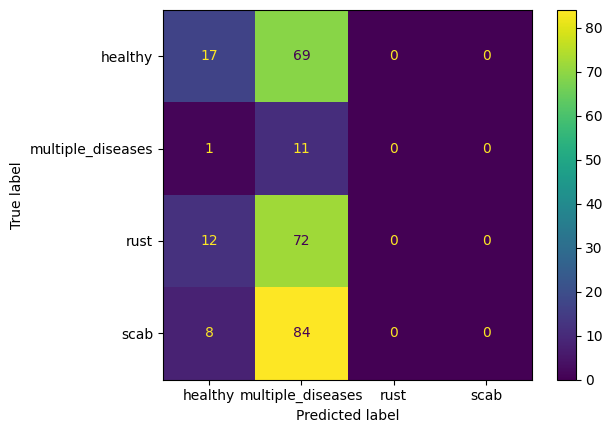

In [ ]:
# showing the results on the test data: accuracy, f1-score and the confusion matrix
show_results(model)

# Transferred Learning

In [ ]:
# mean ans standard deviation of the Imagenet dataset for normalizing or images
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [ ]:
# importing the pre-trained resnet18 model to be used as a feature ectractor, hence removed the last layer
resnet_ = Sequential(*list(resnet18(weights=ResNet18_Weights).children())[:-1])
# splitting the dataset into training and testing
x_train, x_test, y_train, y_test = train_test_split(np.array(df.image_id.values), np.array(df[cols].values), test_size=0.30)
# obtaining the features for all the images to be used as the input to the simple machine learning models
x_train = list(map(lambda x: features(x, img_size, resnet_), x_train))
x_test = list(map(lambda x: features(x, img_size, resnet_), x_test))
# converting the label vectors into labels for the models
y_train, y_test = map(lambda x: np.argmax(x, axis=1), (y_train, y_test))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# training a Logistic Regressor on the dataset
model = LogisticRegression(class_weight='balanced')
model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced')

Accuracy: 0.526508226691042, 
F1 score: 0.5353915453332295


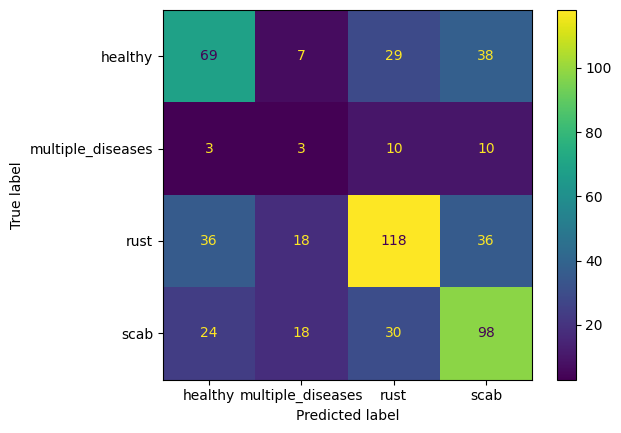

In [ ]:
# showing the results on the test data: accuracy, f1-score and the confusion matrix
show_results(model)

In [ ]:
# training a Support Vector Classifier on the dataset
model = SVC()
model.fit(x_train, y_train)

SVC()

Accuracy: 0.5648994515539305, 
F1 score: 0.539584690903214


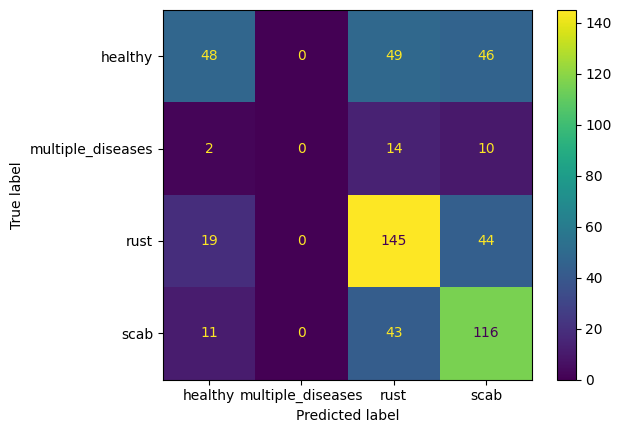

In [ ]:
# showing the results on the test data: accuracy, f1-score and the confusion matrixshow_results(model)

In [ ]:
# training a Simple Neural Network with a single hidden layer on the dataset
model = MLPClassifier()
model.fit(x_train, y_train)

MLPClassifier()

Accuracy: 0.40219378427787933, 
F1 score: 0.27629571038695044


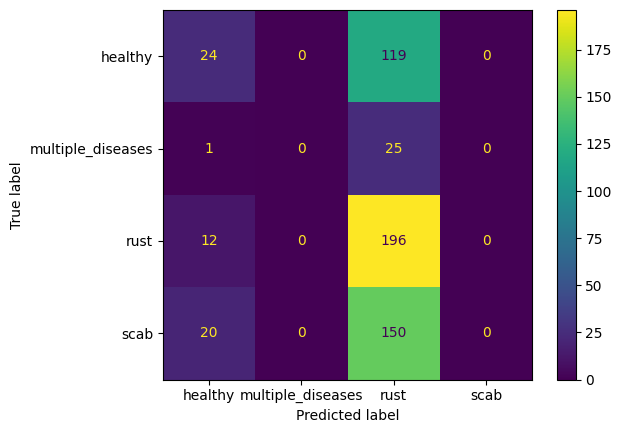

In [ ]:
# showing the results on the test data: accuracy, f1-score and the confusion matrix
show_results(model)

## References

1. R. Dhivya, R Vennila, G Rohini, S Mithila, K Kavitha ``Foilar Disease Classification in Apple Trees,'' 2021 International Conference on Advancements in Electrical, Electronics, Communication, Computing and Automation
2. Kaggle Dataset used for the project Link: https://www.kaggle.com/code/tarunpaparaju/plant-pathology-2020-eda-models
3. ResNet50, VGG16, DenseNet121 tutorials used Link : https://keras.io/api/applications/
4. Inspiration: https://www.kaggle.com/code/tarunpaparaju/plant-pathology-2020-eda-models#Modeling-